# Gating
Gating is the process of retaining events that satisfy some criteria, and discarding the ones that do not.

## Packages

In [1]:
import FlowCal
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")

## Removing Saturated Events

In [2]:
s = FlowCal.io.FCSData("sample006.fcs")
s = FlowCal.transform.to_rfi(s)

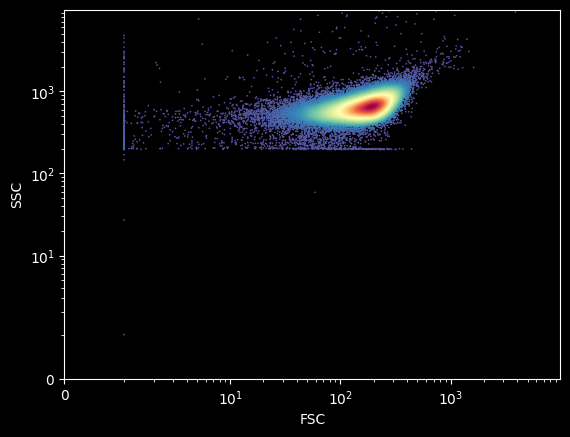

In [3]:
FlowCal.plot.density2d(
    s,
    channels=["FSC", "SSC"],
    mode="scatter",
)

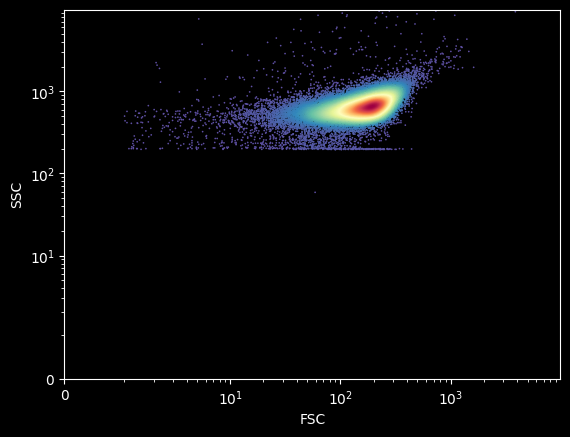

In [4]:
s_g1 = FlowCal.gate.high_low(
    s,
    channels=["FSC", "SSC"],
)
FlowCal.plot.density2d(
    s_g1,
    channels=["FSC", "SSC"],
    mode="scatter",
)

> The line on the upper left has been removed.

Let's further remove the **_horizontal_ line** (i.e. the debris) from `s_g1`, giving birth to `s_g2`.

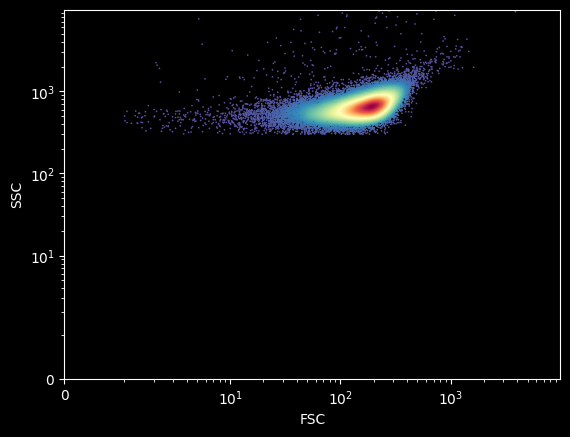

In [5]:
s_g2 = FlowCal.gate.high_low(
    s_g1,
    channels=["SSC"],
    low=300,
)
FlowCal.plot.density2d(
    s_g2,
    channels=["FSC", "SSC"],
    mode="scatter",
)

**(?)** How do we know which value to take for `low`?  
> This approach, however, requires one to estimate a low threshold value for every sample manually. In addition, we usually want events in the densest forward scatter/side scatter region, which requires a more complex shape than a pair of thresholds. We will now explore better ways to achieve this.

## Ellipse Gate

This is like taking an elliptical mask in Computer Vision.

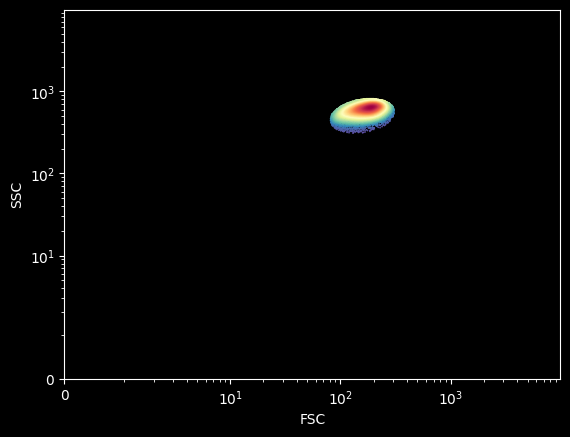

In [6]:
s_g3 = FlowCal.gate.ellipse(
    s_g1,
    channels=["FSC", "SSC"],
    log=True,
    center=(2.2, 2.7),
    a=0.3,
    b=0.2,
    theta=np.pi/10,
)
FlowCal.plot.density2d(
    s_g3,
    channels=["FSC", "SSC"],
    mode="scatter",
)

Some explanations might come in handy here
1. Some of the naming of the input args is quite self-explanatory
    - `center`, `a`, `b`, `theta` are center, major axis, minor axis, rotation angle of the ellipse
    - `log=True` simply expresses that we'd like to specify `center`, `a`, `b` in log scale. In other words, we specify only the exponential part.

But this ellipse gate thing is **too manual**. It requires too much human intervention:
- Looking at the density plot
- Figuring out which ellipse might be a good mask for the densest region
- Etc.

## Density Gate

`FlowCal.gate.density2d` automatically identifies the region with the highest density of events in a two-dimensional diagram, and calculates how big it should be to capture a certain percentage of the total event count. One advantage is that the number of user-defined parameters is reduced to one.

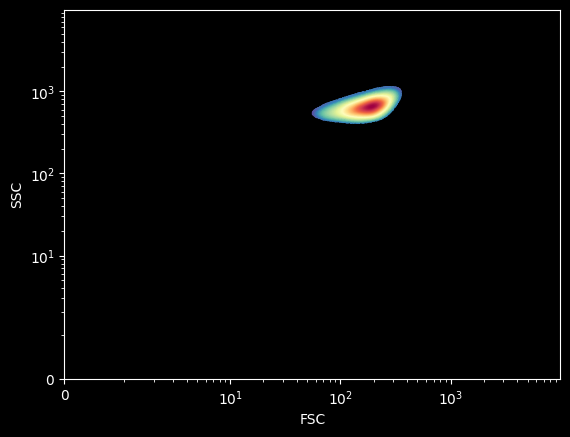

In [7]:
s_g4 = FlowCal.gate.density2d(
    s_g1,
    channels=["FSC", "SSC"],
    gate_fraction=0.75,
)
FlowCal.plot.density2d(
    s_g4,
    channels=["FSC", "SSC"],
    mode="scatter",
)

The parameter `gating_fraction` allows the user to control the fraction of events to retain.

## Visualization

The `FlowCal.plot.density_and_hist` function that we saw in this tutorial could
also be used to visualize the before and after effects of gating.
To that end, let's first study another input arg of the density gating function
`FlowCal.gate.density2d`: `full_output`.

In [8]:
# FlowCal.gate.density2d?

In [9]:
s_g5, mask_g5, contour_g5, *remainder = FlowCal.gate.density2d(
    s_g1,
    channels=["FSC", "SSC"],
    gate_fraction=0.75,
    full_output=True,
)

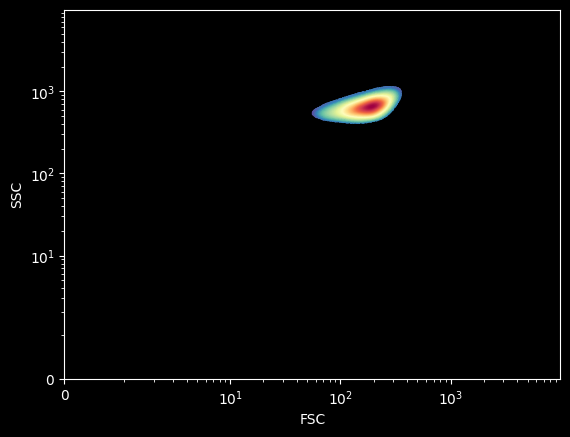

In [10]:
FlowCal.plot.density2d(
    s_g5,
    channels=["FSC", "SSC"],
    mode="scatter",
)

In [11]:
np.array_equal(s_g5, s_g4)

True

In [12]:
remainder

[(array([-3.17430151e-03,  3.17430151e-03,  9.52323017e-03, ...,
          9.76102689e+03,  9.86039553e+03,  9.96077576e+03]),
  array([-3.17430151e-03,  3.17430151e-03,  9.52323017e-03, ...,
          9.76102689e+03,  9.86039553e+03,  9.96077576e+03])),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])]

The extra argument, `full_output`, is available in **every** function in `FlowCal.gate`. When it's flagged as `True`, the called function simply
returns more outputs, giving more information, e.g. for plotting purposes.

In particular, in the above case, we are mainly interested in the first three:
1. `s_g5` is the same `FlowCal.io.FCSData` object as `s_g4`
2. `mask_g5` gives the mask for masking `s_g1` to obtain `s_g5`
3. `contour_g5`: Pretty much the same as `mask_g5`, the contour of the high-density region

With these sorted out, we are ready to plot.

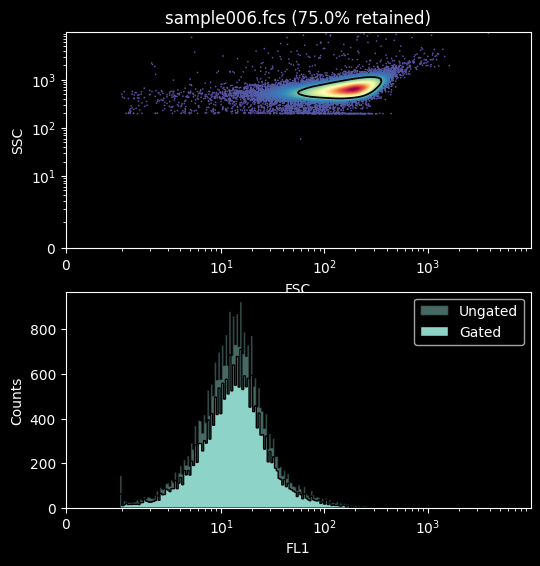

In [13]:
FlowCal.plot.density_and_hist(
    s_g1,
    gated_data=s_g5,
    gate_contour=contour_g5,
    density_channels=["FSC", "SSC"],
    density_params={"mode": "scatter"},
    hist_channels=["FL1"],
)

## Summary
So it seems that conventionally we'd usually do a 2-step processing in gating
1. Use `FlowCal.gate.high_low` with no user-specified input arg to obtain a first gated data (eliminating the noisy high-density region on the left)
1. Use `FlowCal.gate.density2d` to further select the high-density region, which are most likely be the right region for the cell(s)